In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `~/git/projects/perspective_heart_and_brain`


## Download example ECG data
taken from https://physionet.org/content/ecg-fragment-high-risk-label/1.0.0/

In [2]:
# selected datasets for the plots stored in dictionary
# notice the mapping A->Z, C->N, E->S
datasets = Dict(
    "focus_sinus_fast" => "6_Sinus_rhythm/frag/614_C_N_933_8s_frag",
    "sinus_slow" => "6_Sinus_rhythm/frag/421_C_N_0_1s_frag",
    "focus_vf_irregular_small" => "1_Dangerous_VFL_VF/frag/426_C_VF_454_5s_frag",
    "vf_high" => "1_Dangerous_VFL_VF/frag/419_C_VF_407s_frag",
    "vf_irregular_1" => "1_Dangerous_VFL_VF/frag/422_C_VF_1022s_frag",
    "vf_irregular_2" => "1_Dangerous_VFL_VF/frag/422_C_VF_1048s_frag",
    "vt_low_1" => "4_Potential_Dangerous/frag/418_C_VTLR_758s_frag",
    "vt_low_2" => "4_Potential_Dangerous/frag/430_C_VTLR_1397_3s_frag",
    "vt_high_1" => "3_Threatening_VT/frag/418_C_VTHR_1074_9s_frag",
    "vt_high_2" => "3_Threatening_VT/frag/419_C_VTHR_1355s_frag"
)
path="./data/Nemirko_PhysioNet_2022/"

"./data/Nemirko_PhysioNet_2022/"

In [3]:
# download the specific datasets that we work with if not already downloaded
run(`mkdir -p $(path)`)
for (label,dataset) in datasets
    # create folders needed for dataset
    path_new = joinpath(path, split(datasets[label], "/")[1:end-1]...)
    run(`mkdir -p $(path_new)`)
    # hea file
    link = "https://www.physionet.org/files/ecg-fragment-high-risk-label/1.0.0/"*dataset*".hea"
    download(link, path * dataset * ".hea")
    # dat file
    link = "https://www.physionet.org/files/ecg-fragment-high-risk-label/1.0.0/"*dataset*".dat"
    download(link, path * dataset * ".dat")
end

In [4]:

using CairoMakie
using Random
using Distributions
using StatsBase
using LinearAlgebra
using DSP
using JSON

# inlclude functions to read physionet data
include("../src/read_physionet.jl")

# load path_figures from config_user.json if it exists
path_config = "../config_user.json"
if isfile(path_config)
    config = JSON.parsefile(path_config)
    path_figures = config["path_figures"]
else
    config = JSON.parsefile("../config_default.json")
    path_figures = config["path_figures"]
end
print(path_figures)

/Users/johannes/research/figures_perspective_heart_brain/subfigures/

## Extract ECG traces

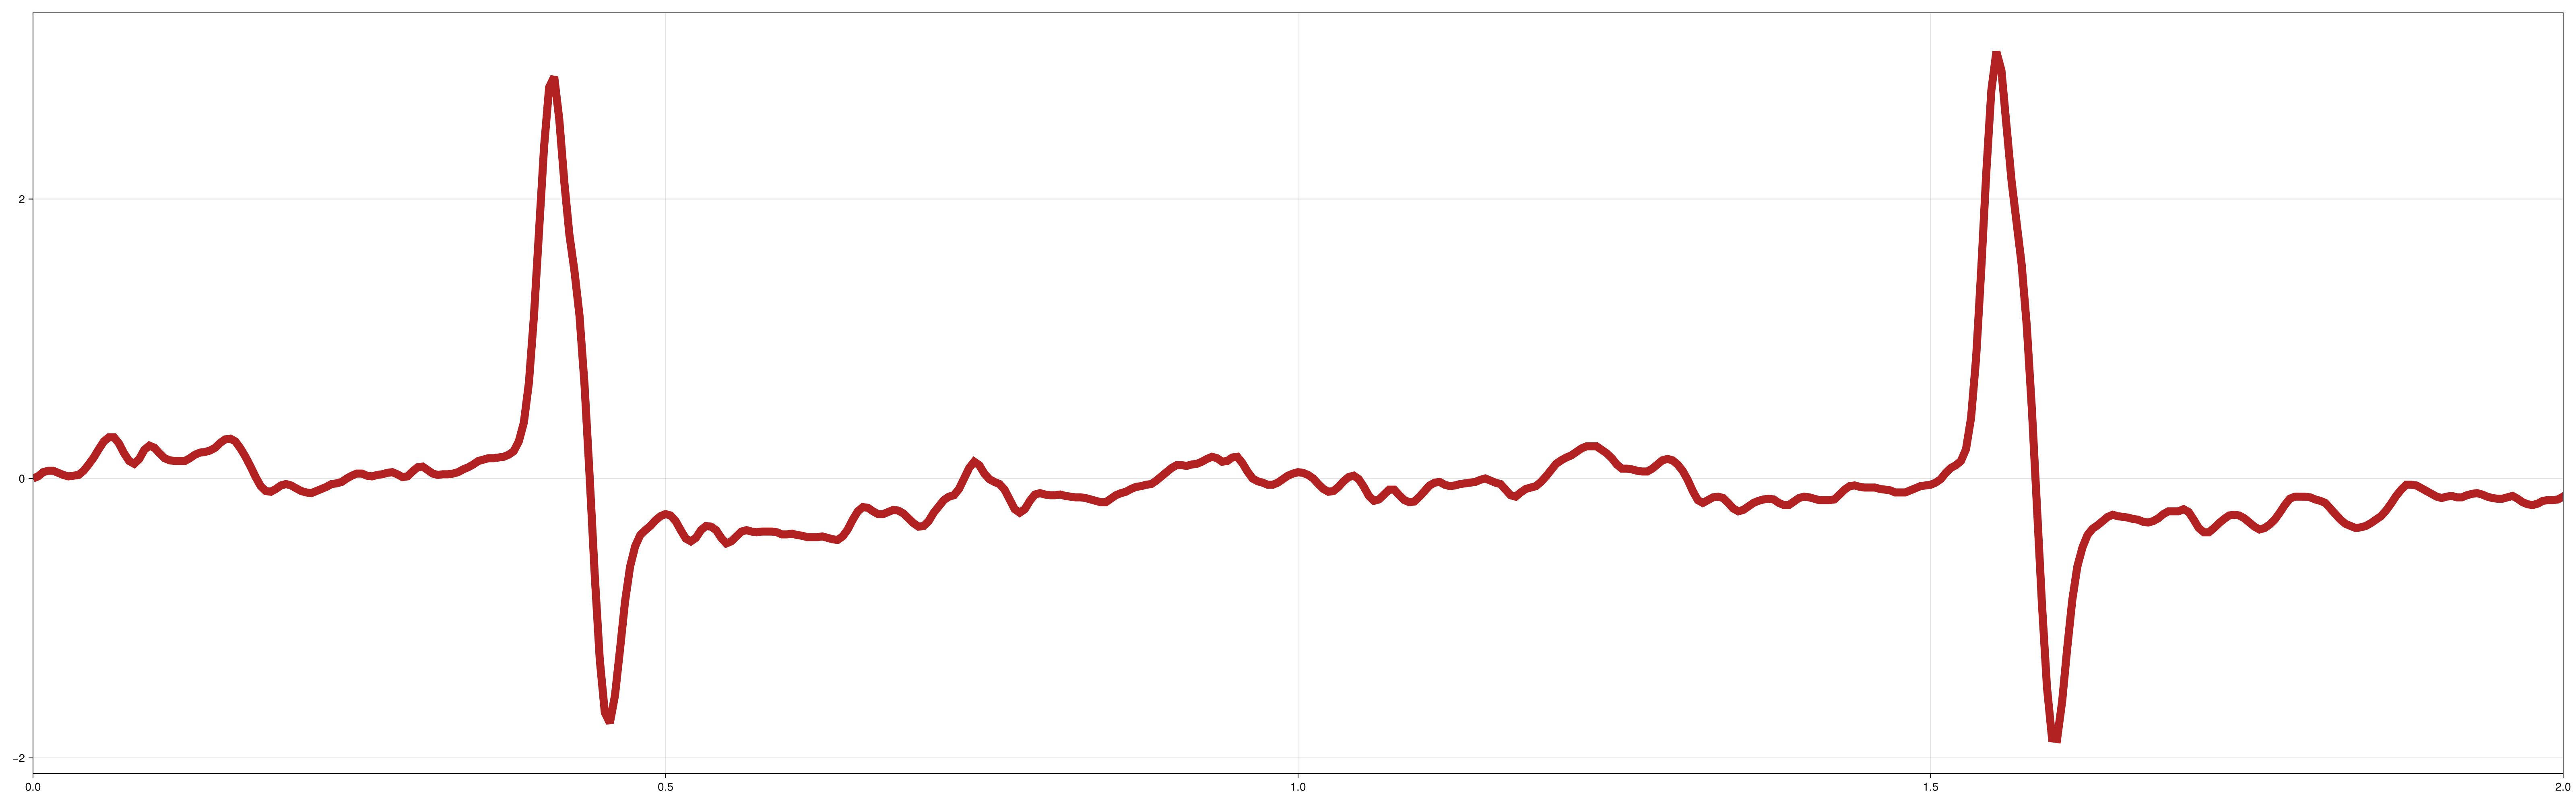

In [5]:
header, signal_or_signals = read_wfdb_record(path * datasets["focus_sinus_fast"])
# quick test plot
signal = header.nsig == 1 ? signal_or_signals : signal_or_signals[1]
time = range(0, length=length(signal), step=1/header.fs)
fig = Figure(size=(3200,1000))
ax = Axis(fig[1, 1])
lines!(ax, time, signal, color=colorant"firebrick", linewidth=10)
xlims!(ax, (0, 2.0))
fig

## Plot all samples

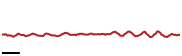

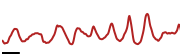

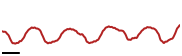

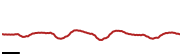

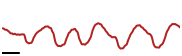

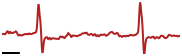

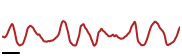

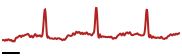

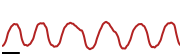

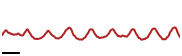

In [8]:
# plot the data (consistent with ecg_data from wfdb packages in python)
inch = 96
mm = 2.83465 # pt
width = 32*mm
height = 10*mm

# set the y-axis limits to account for all datasets
ymins, ymaxs = [], []
ymin_focused, ymax_focused = Inf, -Inf
for (label,dataset) in datasets
    header, signal_or_signals = read_wfdb_record(path * dataset)
    signal = header.nsig == 1 ? signal_or_signals : signal_or_signals[1]
    # de-mean signal
    signal .-= mean(signal)
    push!(ymins, minimum(signal))
    push!(ymaxs, maximum(signal))
    # if label includes focus then update focused limits
    if occursin("focus", label)
        ymin_focused = min(ymin_focused, minimum(signal))
        ymax_focused = max(ymax_focused, maximum(signal))
    end
end
ymin = minimum(ymins)
ymax = maximum(ymaxs)

for (label,dataset) in datasets
    # get data
    header, signal_or_signals = read_wfdb_record(path * dataset)
    signal = header.nsig == 1 ? signal_or_signals : signal_or_signals[1]
    # de-mean signal
    signal .-= mean(signal)
    time = range(0, length=length(signal), step=1/header.fs)

    # plot figure
    fig = Figure(size = (width,height), fontsize=10, figure_padding = 1, backgroundcolor = :transparent)
    ax = Axis(fig[1,1]; xgridvisible = false, ygridvisible = false, backgroundcolor = :transparent)
    hidedecorations!(ax)
    hidespines!(ax)
    lines!(ax, time, signal, color = colorant"firebrick", linewidth = 1)
    xlims!(ax, (0, 2))
    ylims!(ax, (ymin, ymax))
        
    # scale bar as black line for duration of 200ms below the signal
    lines!(ax, [0.0, 0.2], [ymin, ymin], color = :black, linewidth = 2)

    # save as pdf with transparent background
    save(path_figures*"data_ecg_$label.pdf", fig, pt_per_unit = 1)
    display(fig)
end